In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

file_list=[]
file_list_train=[]
file_list_test=[]

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_list.append(os.path.join(dirname, filename))

PATH = '/kaggle/input/predict-volcanic-eruptions-ingv-oe/'

for dirname, _, filenames in os.walk('/kaggle/input/predict-volcanic-eruptions-ingv-oe/train'):
    for filename in filenames:
        file_list_train.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/predict-volcanic-eruptions-ingv-oe/test'):
    for filename in filenames:
        file_list_test.append(os.path.join(dirname, filename))

In [20]:
print(file_list[0])
print(pd.read_csv(file_list[0]))

/kaggle/input/predict-volcanic-eruptions-ingv-oe/sample_submission.csv
      segment_id  time_to_eruption
0     1000213997                 0
1      100023368                 0
2     1000488999                 0
3     1001028887                 0
4     1001857862                 0
...          ...               ...
4515   996704281                 0
4516   997630809                 0
4517   998072137                 0
4518   998136924                 0
4519    99975682                 0

[4520 rows x 2 columns]


In [21]:
print(file_list_train[0])
print(pd.read_csv(file_list_train[0]))

/kaggle/input/predict-volcanic-eruptions-ingv-oe/train/800654756.csv
       sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0        -560.0    -508.0       NaN    -261.0    -348.0    1681.0    -764.0   
1        -508.0    -460.0       NaN    -276.0    -252.0    1934.0    -774.0   
2        -630.0    -260.0       NaN    -310.0    -174.0    2229.0    -785.0   
3        -587.0       1.0       NaN    -352.0     -69.0    2069.0    -788.0   
4        -778.0     240.0       NaN    -390.0      71.0    1850.0    -825.0   
...         ...       ...       ...       ...       ...       ...       ...   
59996     232.0    -151.0       NaN    -192.0     126.0   -1189.0    -578.0   
59997     154.0    -119.0       NaN    -230.0     105.0    -942.0    -766.0   
59998     376.0     -67.0       NaN    -285.0      25.0    -747.0    -958.0   
59999     289.0     -97.0       NaN    -348.0      -3.0    -302.0    -984.0   
60000     222.0     -70.0       NaN    -369.0     -44.0     23

In [22]:
print(file_list[1])
print(pd.read_csv(file_list[1]))

/kaggle/input/predict-volcanic-eruptions-ingv-oe/train.csv
      segment_id  time_to_eruption
0     1136037770          12262005
1     1969647810          32739612
2     1895879680          14965999
3     2068207140          26469720
4      192955606          31072429
...          ...               ...
4426   873340274          15695097
4427  1297437712          35659379
4428   694853998          31206935
4429  1886987043           9598270
4430  1100632800          20128938

[4431 rows x 2 columns]


In [23]:
#file_list_test
print(len(file_list_test))
keys = list(pd.read_csv(file_list_test[0]).keys())
print(keys)
nanCount = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for index in range(len(file_list_test)):
    if(index % 200 == 0):
        print(index)
    df = pd.read_csv(file_list_test[index])
    for key in df.keys():
        if df[key].isna().sum() == 60001:
            nanCount[keys.index(key)] += 1
print(nanCount)
data={'sensors': keys, 'count': nanCount}
myFrame = pd.DataFrame(data)
print(myFrame)

4520
['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10']
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
[387, 1257, 434, 0, 1388, 0, 34, 294, 817, 760]
     sensors  count
0   sensor_1    387
1   sensor_2   1257
2   sensor_3    434
3   sensor_4      0
4   sensor_5   1388
5   sensor_6      0
6   sensor_7     34
7   sensor_8    294
8   sensor_9    817
9  sensor_10    760


<AxesSubplot:xlabel='sensors'>

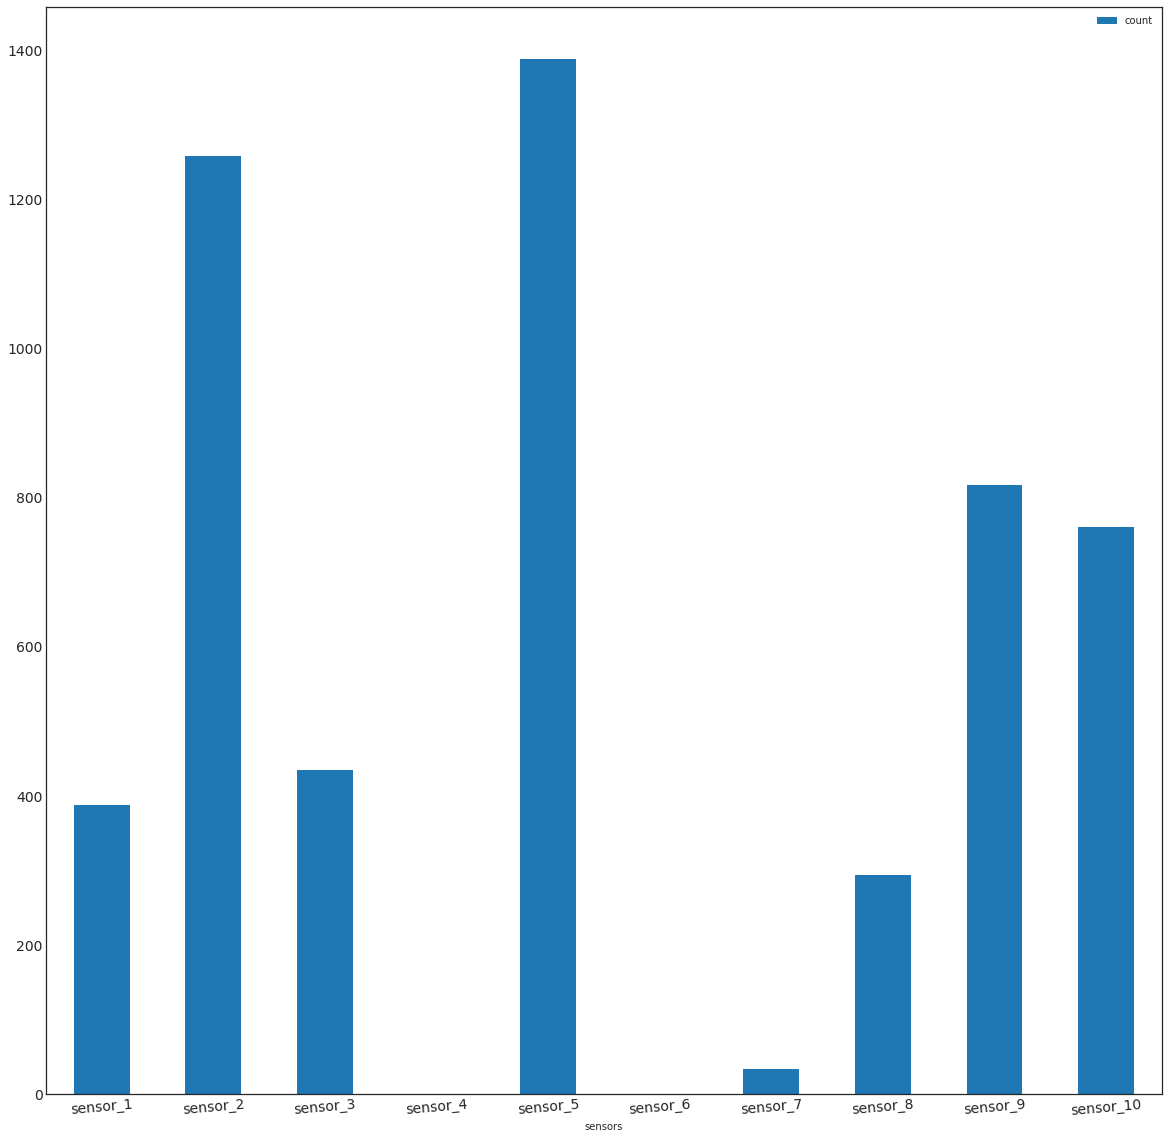

In [24]:
myFrame.plot(figsize =(20, 20), x="sensors", y="count", kind="bar",  rot=5, fontsize=14 )

In [25]:
print(file_list_test[0])
print(pd.read_csv(file_list_test[0]))

/kaggle/input/predict-volcanic-eruptions-ingv-oe/test/473253715.csv
       sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0        -511.0       NaN    -131.0    -457.0      47.0     -35.0     185.0   
1        -556.0       NaN    -105.0    -534.0      -7.0     -84.0     190.0   
2        -615.0       NaN     -97.0    -473.0     -50.0       8.0     219.0   
3        -682.0       NaN     -75.0    -388.0     -58.0      28.0     255.0   
4        -763.0       NaN     -18.0    -358.0     -53.0    -104.0     271.0   
...         ...       ...       ...       ...       ...       ...       ...   
59996    -580.0       NaN     -95.0    -614.0     -75.0     198.0     127.0   
59997    -546.0       NaN     -88.0    -843.0     -48.0      82.0      53.0   
59998    -522.0       NaN    -147.0   -1006.0     -33.0     175.0     -27.0   
59999    -516.0       NaN    -129.0   -1085.0       0.0     235.0     -94.0   
60000    -493.0       NaN    -174.0   -1172.0      63.0     123

In [26]:
print(len(file_list_test))

4520


In [27]:
print(len(file_list_train))

4431


In [28]:
files_train = [file.split('/')[-1].split('.')[-2] for file in file_list_train]
files_test = [file.split('/')[-1].split('.')[-2] for file in file_list_test]
print(files_train[0:10])
print(files_test[0:10])

['800654756', '321543978', '1417547769', '729870090', '830695026', '1804779174', '2146132452', '1027307874', '846647124', '1973467302']
['473253715', '698018079', '1102809614', '1087681649', '1939361933', '1612001071', '1995599794', '470147329', '1757905171', '854148244']


In [29]:
test_set = set(files_test)
train_set = set(files_train)
inter = test_set.intersection(train_set)
print(inter)

set()


In [30]:
train = pd.read_csv(PATH+'train.csv')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_to_eruption', ylabel='Density'>

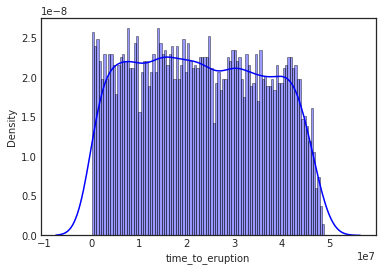

In [31]:
sns.distplot(train['time_to_eruption'], hist=True, kde=True, bins=100, color='blue', hist_kws={'edgecolor':'black'})

In [32]:
train['time_to_eruption'].describe()

count    4.431000e+03
mean     2.284891e+07
std      1.348439e+07
min      6.250000e+03
25%      1.127016e+07
50%      2.246559e+07
75%      3.434356e+07
max      4.904609e+07
Name: time_to_eruption, dtype: float64

array([[<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>]], dtype=object)

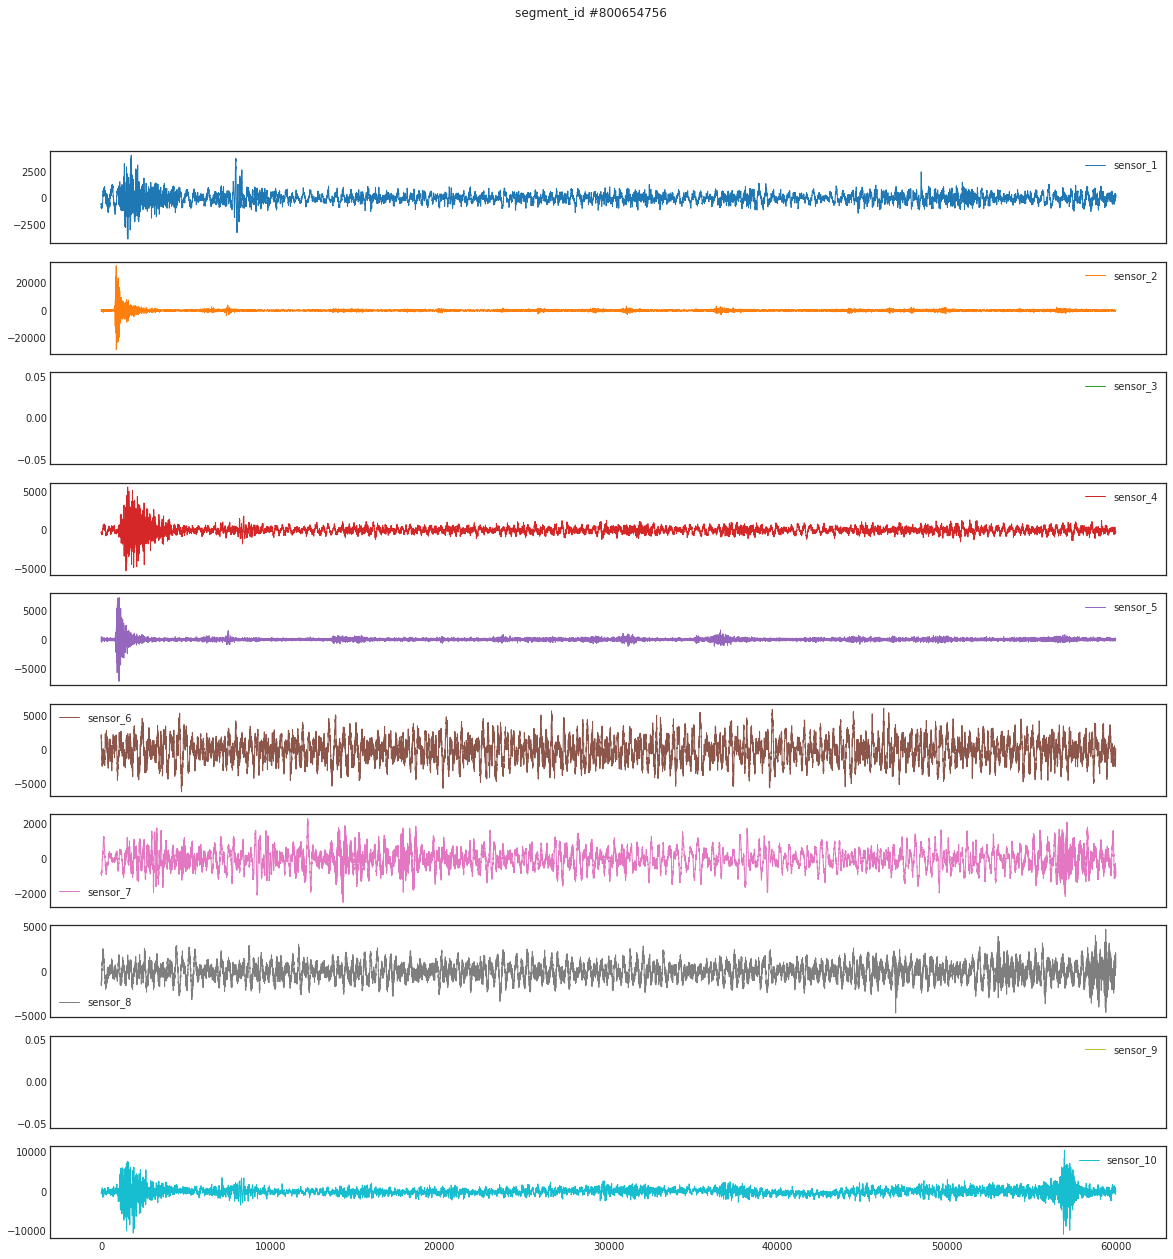

In [33]:
df_segment_id = pd.read_csv(PATH+'/train/800654756.csv')

df_segment_id.plot(figsize=(20, 20), subplots=True, layout=(10, 1), rot = 0,
                  lw=1, title='segment_id #800654756')

In [34]:
display(train.sort_values('time_to_eruption', axis=0, ascending=True).iloc[[0, -1], :])

segment_id_min = 601524801
segment_id_max = 1923243961

df_segment_id_min = pd.read_csv(PATH+'/train/'+str(segment_id_min)+'.csv')
df_segment_id_max = pd.read_csv(PATH+'/train/'+str(segment_id_max)+'.csv')

,segment_id,time_to_eruption
590,601524801,6250
1139,1923243961,49046087


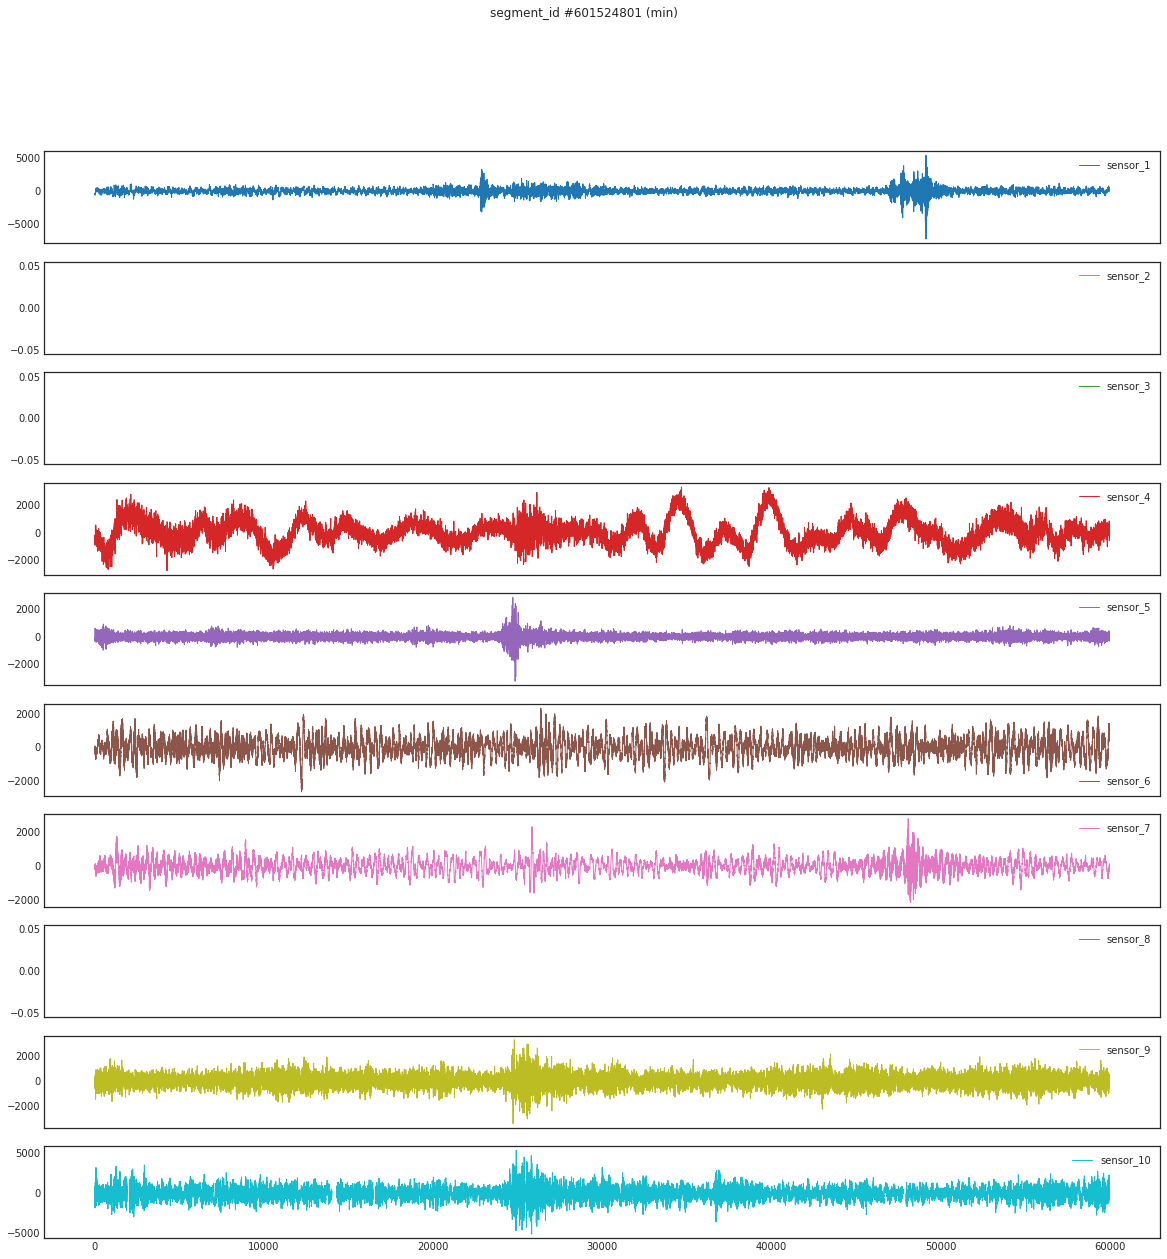

In [35]:
df_segment_id_min.plot(figsize=(20,20), subplots=True, layout=(10,1), rot=0, lw=1, title='segment_id #601524801 (min)')
plt.show()


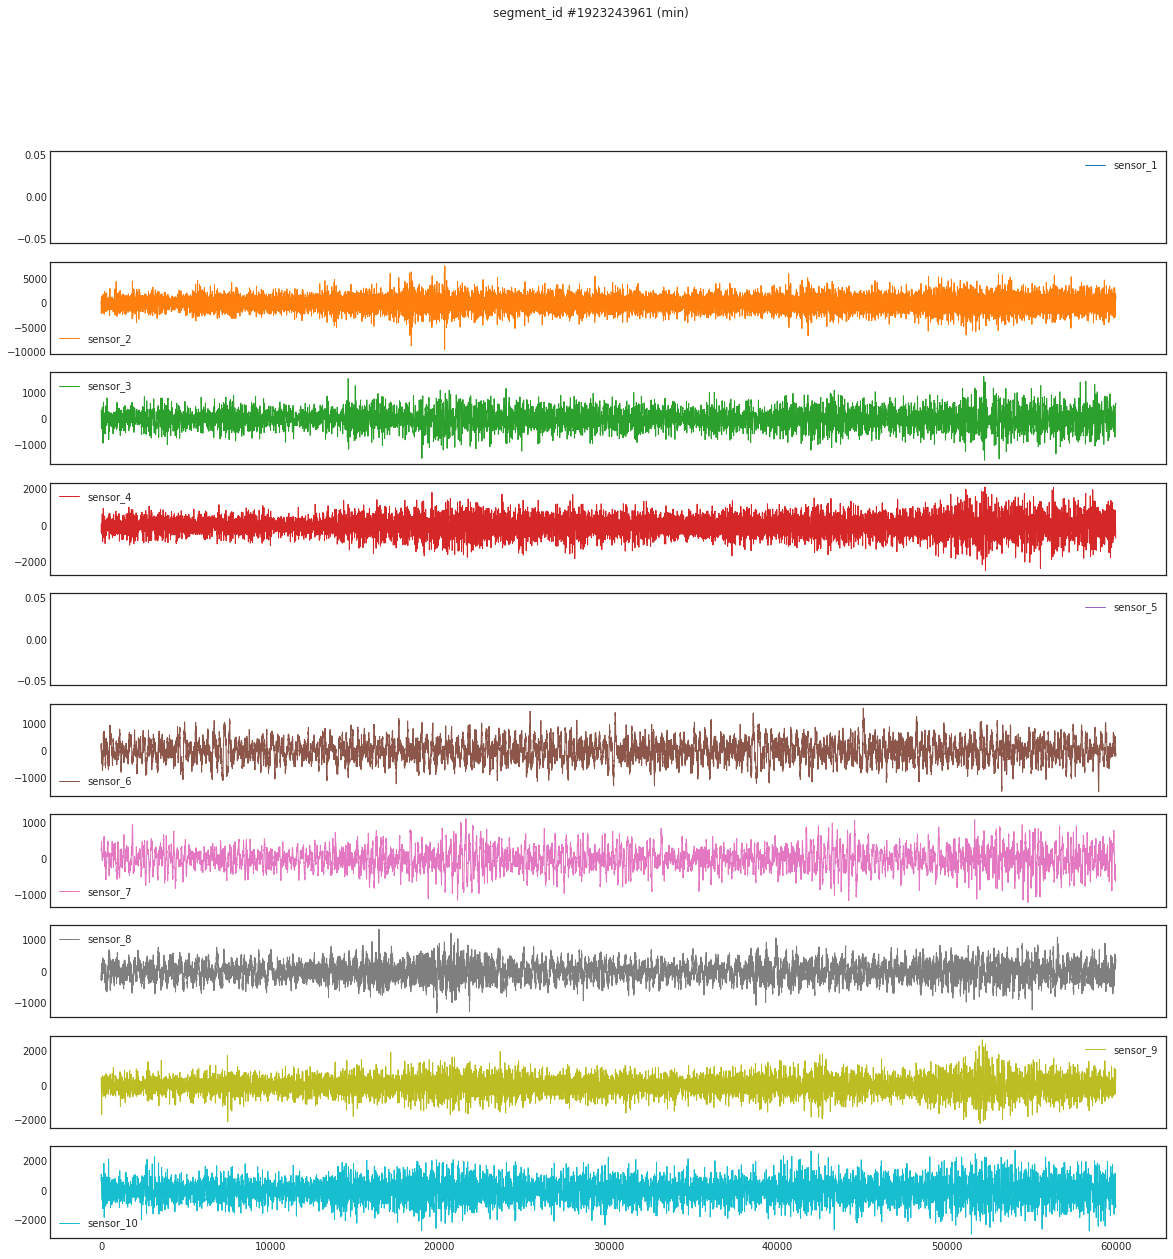

In [36]:
df_segment_id_max.plot(figsize=(20,20), subplots=True, layout=(10,1), rot=0, lw=1, title='segment_id #1923243961 (min)')
plt.show()

In [37]:
def build_features(signal, ts, sensor_id):
    X = pd.DataFrame()
    f = np.fft.fft(signal)
    f_real = np.real(f)
    X.loc[ts, f'{sensor_id}_sum'] = signal.sum()
    X.loc[ts, f'{sensor_id}_mean'] = signal.mean()
    X.loc[ts, f'{sensor_id}_std'] = signal.std()
    X.loc[ts, f'{sensor_id}_var'] = signal.var()
    X.loc[ts, f'{sensor_id}_max'] = signal.max()
    X.loc[ts, f'{sensor_id}_min'] = signal.min()
    X.loc[ts, f'{sensor_id}_skew'] = signal.skew()
    X.loc[ts, f'{sensor_id}_mad'] = signal.mad()
    X.loc[ts, f'{sensor_id}_kurtosis'] = signal.kurtosis()
    X.loc[ts, f'{sensor_id}_quantile99'] = np.quantile(signal, 0.99)
    X.loc[ts, f'{sensor_id}_quantile95'] = np.quantile(signal, 0.95)
    X.loc[ts, f'{sensor_id}_quantile85'] = np.quantile(signal, 0.85)
    X.loc[ts, f'{sensor_id}_quantile75'] = np.quantile(signal, 0.75)
    X.loc[ts, f'{sensor_id}_quantile55'] = np.quantile(signal, 0.55)
    X.loc[ts, f'{sensor_id}_quantile45'] = np.quantile(signal, 0.45)
    X.loc[ts, f'{sensor_id}_quantile25'] = np.quantile(signal, 0.25)
    X.loc[ts, f'{sensor_id}_quantile15'] = np.quantile(signal, 0.15)
    X.loc[ts, f'{sensor_id}_quantile05'] = np.quantile(signal, 0.05)
    X.loc[ts, f'{sensor_id}_quantile01'] = np.quantile(signal, 0.01)
    X.loc[ts, f'{sensor_id}_fft_real_mean'] = f_real.mean()
    X.loc[ts, f'{sensor_id}_fft_real_std'] = f_real.std()
    X.loc[ts, f'{sensor_id}_fft_real_max'] = f_real.max()
    X.loc[ts, f'{sensor_id}_fft_real_min'] = f_real.min()
    
    return X

In [38]:
from itertools import islice


train_set = list()
seg=0
print(enumerate(train.segment_id))

for seg, segment_id in enumerate(train.segment_id):
    signals = pd.read_csv(PATH+'/train/'+str(segment_id)+'.csv')
    train_row=[]
#     print(segment_id)
    if seg % 200 == 0:
        print('Processing segment_id={}'.format(seg))
    
    for sensor in range(0, 10):
        sensor_id = f'sensor_{sensor+1}'
        train_row.append(build_features(signals[sensor_id].fillna(0), segment_id, sensor_id))
    
    train_row = pd.concat(train_row, axis=1)
    train_set.append(train_row)
    seg+=1
    
train_set = pd.concat(train_set)
print(train_set)

Processing segment_id=0
Processing segment_id=200
Processing segment_id=400
Processing segment_id=600
Processing segment_id=800
Processing segment_id=1000
Processing segment_id=1200
Processing segment_id=1400
Processing segment_id=1600
Processing segment_id=1800
Processing segment_id=2000
Processing segment_id=2200
Processing segment_id=2400
Processing segment_id=2600
Processing segment_id=2800
Processing segment_id=3000
Processing segment_id=3200
Processing segment_id=3400
Processing segment_id=3600
Processing segment_id=3800
Processing segment_id=4000
Processing segment_id=4200
Processing segment_id=4400
            sensor_1_sum  sensor_1_mean  sensor_1_std   sensor_1_var  \
1136037770      -96621.0      -1.610323    303.096099   91867.245099   
1969647810       85569.0       1.426126    438.360560  192159.980413   
1895879680      150278.0       2.504592    241.575415   58358.681050   
2068207140      129950.0       2.165797    221.967825   49269.715377   
192955606         4429.0  

In [39]:
train_set = train_set.reset_index()
train_set = train_set.rename(columns={'index': 'segment_id'})
print(train_set)
train_set = pd.merge(train_set, train, on='segment_id')
print(train_set)


      segment_id  sensor_1_sum  sensor_1_mean  sensor_1_std   sensor_1_var  \
0     1136037770      -96621.0      -1.610323    303.096099   91867.245099   
1     1969647810       85569.0       1.426126    438.360560  192159.980413   
2     1895879680      150278.0       2.504592    241.575415   58358.681050   
3     2068207140      129950.0       2.165797    221.967825   49269.715377   
4      192955606        4429.0       0.073815    261.695935   68484.762635   
...          ...           ...            ...           ...            ...   
4426   873340274       54405.0       0.906735    613.427301  376293.054135   
4427  1297437712      476221.0       7.936884    649.089618  421317.332733   
4428   694853998       85261.0       1.420993    110.942596   12308.259562   
4429  1886987043       54350.0       0.905818    478.852581  229299.794013   
4430  1100632800     -248575.0      -4.142848    272.632730   74328.605478   

      sensor_1_max  sensor_1_min  sensor_1_skew  sensor_1_mad  

In [40]:
print(train_set.head(3))

   segment_id  sensor_1_sum  sensor_1_mean  sensor_1_std   sensor_1_var  \
0  1136037770      -96621.0      -1.610323    303.096099   91867.245099   
1  1969647810       85569.0       1.426126    438.360560  192159.980413   
2  1895879680      150278.0       2.504592    241.575415   58358.681050   

   sensor_1_max  sensor_1_min  sensor_1_skew  sensor_1_mad  sensor_1_kurtosis  \
0        1353.0       -1421.0      -0.057494    238.836278           0.247736   
1        2197.0       -2005.0      -0.001189    334.894305           1.177624   
2        1148.0       -1115.0       0.071632    189.198970           0.567813   

   ...  sensor_10_quantile45  sensor_10_quantile25  sensor_10_quantile15  \
0  ...                 -77.0                -406.0                -616.0   
1  ...                -101.0                -547.0                -864.0   
2  ...                 -59.0                -323.0                -497.0   

   sensor_10_quantile05  sensor_10_quantile01  sensor_10_fft_real_mea

In [41]:
test_files = []
for dirname, _, filenames in os.walk(PATH+'/test/'):
    for filename in filenames:
        test_files.append(filename[:-4])

test = pd.DataFrame(test_files, columns=['segment_id'])

In [42]:
test_set = list()
seg=0

for seg, segment_id in enumerate(test.segment_id):
    signals = pd.read_csv(PATH+'/test/'+str(segment_id)+'.csv')
    test_row=[]
    
    if seg%200 == 0:
        print('Processing segment_id={}'.format(seg))
        
    for sensor in range(0, 10):
        sensor_id = f'sensor_{sensor+1}'
        test_row.append(build_features(signals[sensor_id].fillna(0), segment_id, sensor_id))
    
    test_row = pd.concat(test_row, axis=1)
    test_set.append(test_row)
    seg+=1
    
test_set = pd.concat(test_set)
print(test_set)

Processing segment_id=0
Processing segment_id=200
Processing segment_id=400
Processing segment_id=600
Processing segment_id=800
Processing segment_id=1000
Processing segment_id=1200
Processing segment_id=1400
Processing segment_id=1600
Processing segment_id=1800
Processing segment_id=2000
Processing segment_id=2200
Processing segment_id=2400
Processing segment_id=2600
Processing segment_id=2800
Processing segment_id=3000
Processing segment_id=3200
Processing segment_id=3400
Processing segment_id=3600
Processing segment_id=3800
Processing segment_id=4000
Processing segment_id=4200
Processing segment_id=4400
            sensor_1_sum  sensor_1_mean  sensor_1_std   sensor_1_var  \
473253715       176053.0       2.934168    469.553705  220480.682099   
698018079      -163264.0      -2.721021    324.254991  105141.299153   
1102809614      -61271.0      -1.021166    187.078093   34998.213019   
1087681649       23641.0       0.394010    220.053325   48423.465637   
1939361933     -217318.0  

In [43]:
test_set=test_set.reset_index()
test_set=test_set.rename(columns={'index': 'segment_id'})
print(test_set)
test_set=pd.merge(test_set, test, on="segment_id")
print(test_set)

      segment_id  sensor_1_sum  sensor_1_mean  sensor_1_std   sensor_1_var  \
0      473253715      176053.0       2.934168    469.553705  220480.682099   
1      698018079     -163264.0      -2.721021    324.254991  105141.299153   
2     1102809614      -61271.0      -1.021166    187.078093   34998.213019   
3     1087681649       23641.0       0.394010    220.053325   48423.465637   
4     1939361933     -217318.0      -3.621906    257.255088   66180.180143   
...          ...           ...            ...           ...            ...   
4515  1716645489       34096.0       0.568257    129.576455   16790.057578   
4516  1799317581     -240731.0      -4.012116    409.858536  167984.019670   
4517  1284692270     -154754.0      -2.579190    256.546140   65815.922033   
4518   531629727       30926.0       0.515425    395.611858  156508.742500   
4519   215827094      -76136.0      -1.268912    208.355434   43411.986968   

      sensor_1_max  sensor_1_min  sensor_1_skew  sensor_1_mad  

In [44]:
print(test_set.head(3))

   segment_id  sensor_1_sum  sensor_1_mean  sensor_1_std   sensor_1_var  \
0   473253715      176053.0       2.934168    469.553705  220480.682099   
1   698018079     -163264.0      -2.721021    324.254991  105141.299153   
2  1102809614      -61271.0      -1.021166    187.078093   34998.213019   

   sensor_1_max  sensor_1_min  sensor_1_skew  sensor_1_mad  sensor_1_kurtosis  \
0        1768.0       -2035.0       0.008376    371.762610           0.170257   
1        1884.0       -2101.0      -0.075053    250.818417           1.160786   
2         811.0        -830.0      -0.048817    147.487040           0.256339   

   ...  sensor_10_quantile55  sensor_10_quantile45  sensor_10_quantile25  \
0  ...                  96.0                 -98.0                -536.0   
1  ...                  69.0                 -70.0                -392.0   
2  ...                   0.0                   0.0                   0.0   

   sensor_10_quantile15  sensor_10_quantile05  sensor_10_quantile01  

In [45]:
X = train_set.drop(['segment_id', 'time_to_eruption'], axis=1)
y = train_set['time_to_eruption']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.head(3))
print('np.shape(X_train) = ', np.shape(X_train))

print(y_train.head(3))
print('np.shape(y_train) = ', np.shape(y_train))

      sensor_1_sum  sensor_1_mean  sensor_1_std   sensor_1_var  sensor_1_max  \
1345      223768.0       3.729405    183.976962   33847.522577        1113.0   
3130     -115501.0      -1.924985    481.973341  232298.301089        2880.0   
4062      -76366.0      -1.272745    406.212407  165008.519825        1721.0   

      sensor_1_min  sensor_1_skew  sensor_1_mad  sensor_1_kurtosis  \
1345        -895.0       0.127015    141.489283           1.192900   
3130       -2757.0      -0.014659    378.111685           0.611876   
4062       -1579.0       0.052022    322.913903           0.102883   

      sensor_1_quantile99  ...  sensor_10_quantile55  sensor_10_quantile45  \
1345                475.0  ...                  49.0                 -48.0   
3130               1133.0  ...                 109.0                -116.0   
4062                968.0  ...                 103.0                 -99.0   

      sensor_10_quantile25  sensor_10_quantile15  sensor_10_quantile05  \
1345       

In [46]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=20, random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, random_state=0)

In [47]:
y_pred = model.predict(X_valid)

Text(0.5, 1.0, 'Nonlinear Regression ')

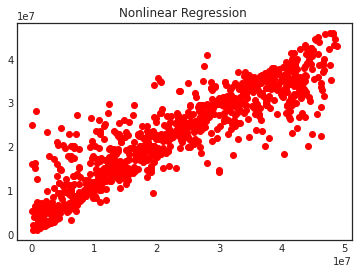

In [48]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_valid, y_pred)
fig=plt.figure()
mulreg = fig.add_subplot(1,1,1)
mulreg.scatter(y_valid, y_pred, color='r')
mulreg.set_title('Nonlinear Regression ')

In [49]:
predictions = model.predict(test_set.drop(columns=['segment_id'], axis=1))

submission = pd.DataFrame()
submission['segment_id'] = test_set['segment_id']
submission['time_to_eruption'] = predictions
submission.to_csv('submission.csv', header=True, index=False)